In [1]:
import pandas as pd
import statsmodels.api as sm

# Завантажуємо вбудований макроекономічний датасет
df = sm.datasets.macrodata.load_pandas().data
#
# Функція для створення дати з року та кварталу
def create_date(row):
    return pd.Timestamp(year=int(row['year']), month=int(row['quarter'] * 3 - 2), day=1)

# Застосовуємо функцію для створення нового стовпця з датою
df['date'] = df.apply(create_date, axis=1)


# Виводимо перші кілька рядків вибраного датафрейму
print(df.head())

     year  quarter   realgdp  realcons  realinv  realgovt  realdpi    cpi  \
0  1959.0      1.0  2710.349    1707.4  286.898   470.045   1886.9  28.98   
1  1959.0      2.0  2778.801    1733.7  310.859   481.301   1919.7  29.15   
2  1959.0      3.0  2775.488    1751.8  289.226   491.260   1916.4  29.35   
3  1959.0      4.0  2785.204    1753.7  299.356   484.052   1931.3  29.37   
4  1960.0      1.0  2847.699    1770.5  331.722   462.199   1955.5  29.54   

      m1  tbilrate  unemp      pop  infl  realint       date  
0  139.7      2.82    5.8  177.146  0.00     0.00 1959-01-01  
1  141.7      3.08    5.1  177.830  2.34     0.74 1959-04-01  
2  140.5      3.82    5.3  178.657  2.74     1.09 1959-07-01  
3  140.0      4.33    5.6  179.386  0.27     4.06 1959-10-01  
4  139.6      3.50    5.2  180.007  2.31     1.19 1960-01-01  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from optimizers import GDOptimizer
from model import NN
from layers import DenseLayer
from activations import ReLU
from losses import MSE
np.random.seed(42) 

# Перетворюємо дані в масиви
# X = df_selected[['m1', 'realinv', 'unemp']].values  # Вхідні змінні
# y = df_selected['cpi'].values  # Цільова змінна
year = df.drop_duplicates("year")
# year = year.tail(80)[::-1]

X = year[['realgdp', 'realcons', 'realinv', 'realgovt',
        'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']].values  # Вхідні змінні
y = year['cpi'].values  # Цільова змінна

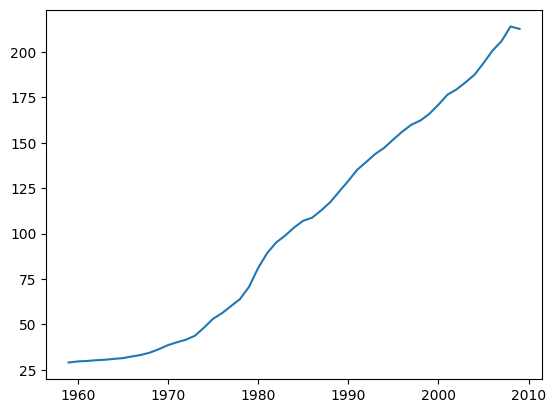

In [3]:
plt.plot(year['year'], year['cpi'])

Training on window 1 (0-20)


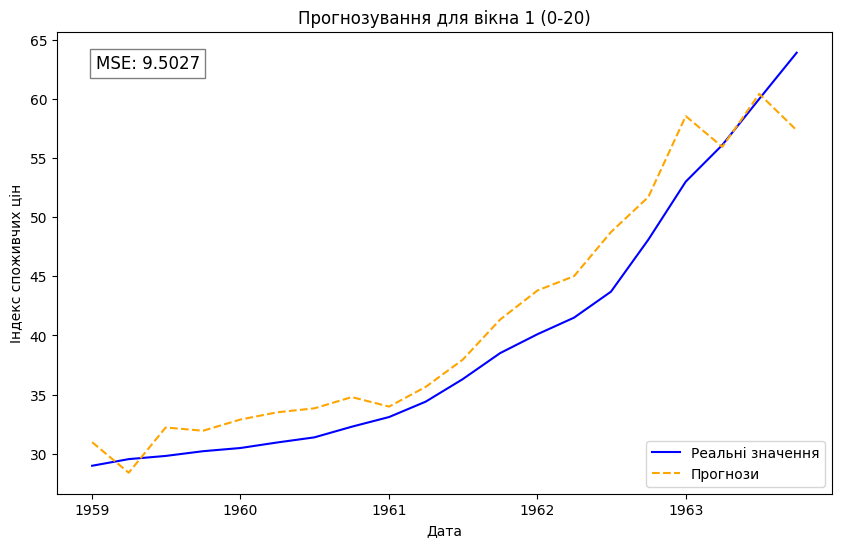

Training on window 2 (1-21)


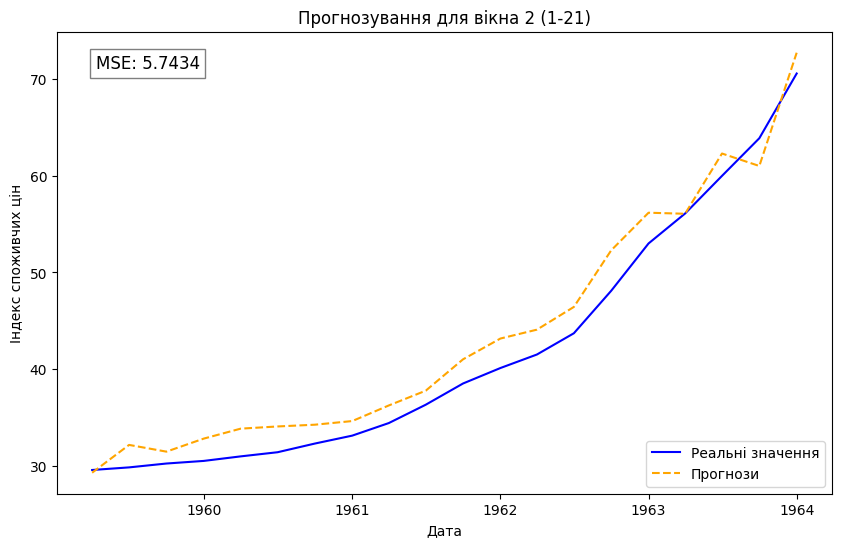

Training on window 3 (2-22)


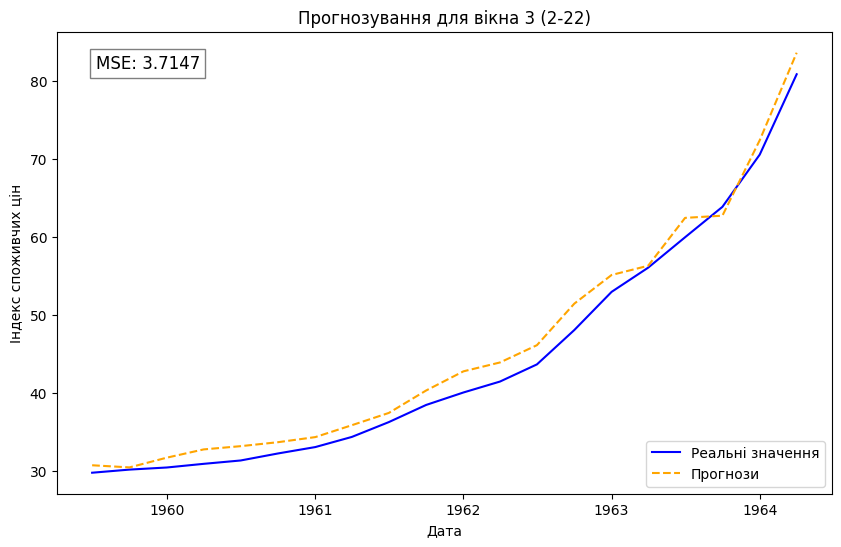

Training on window 4 (3-23)


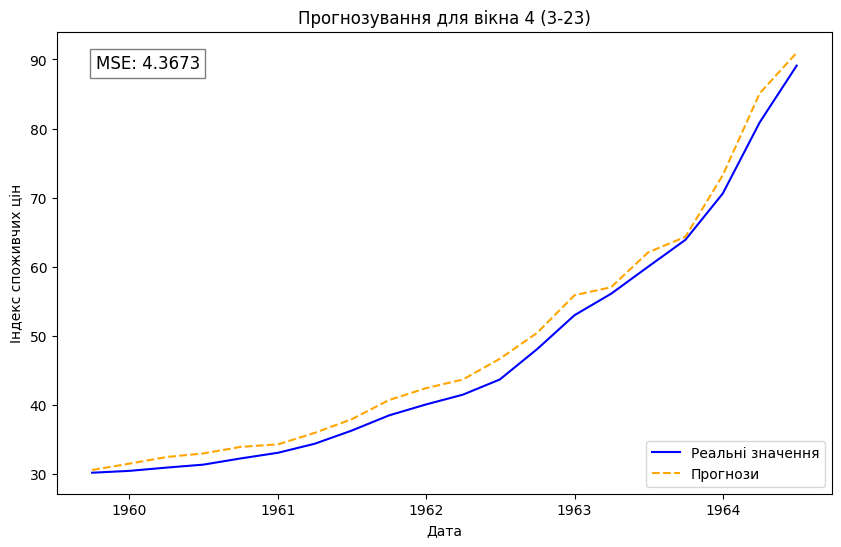

Training on window 5 (4-24)


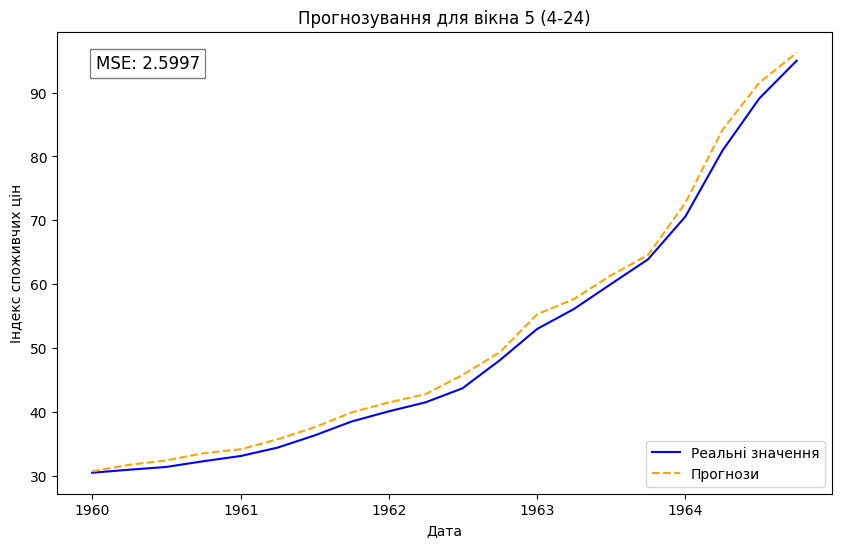

Training on window 6 (5-25)


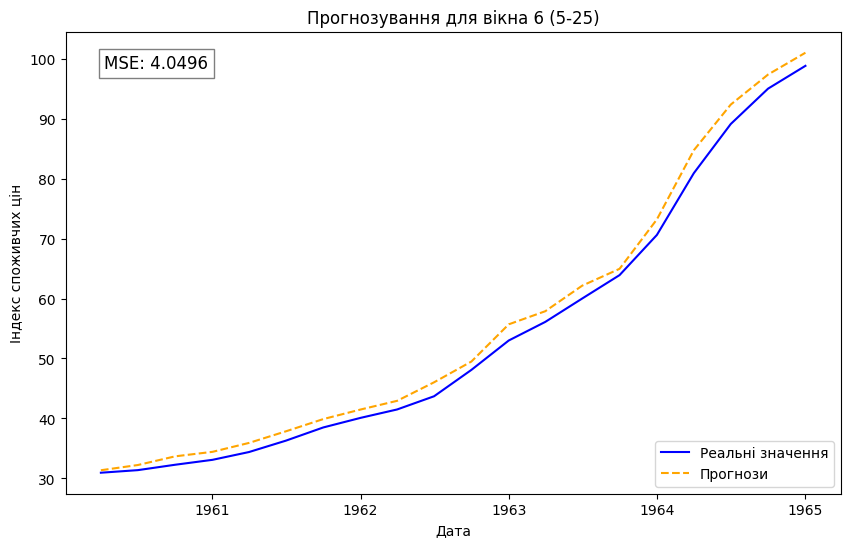

Training on window 7 (6-26)


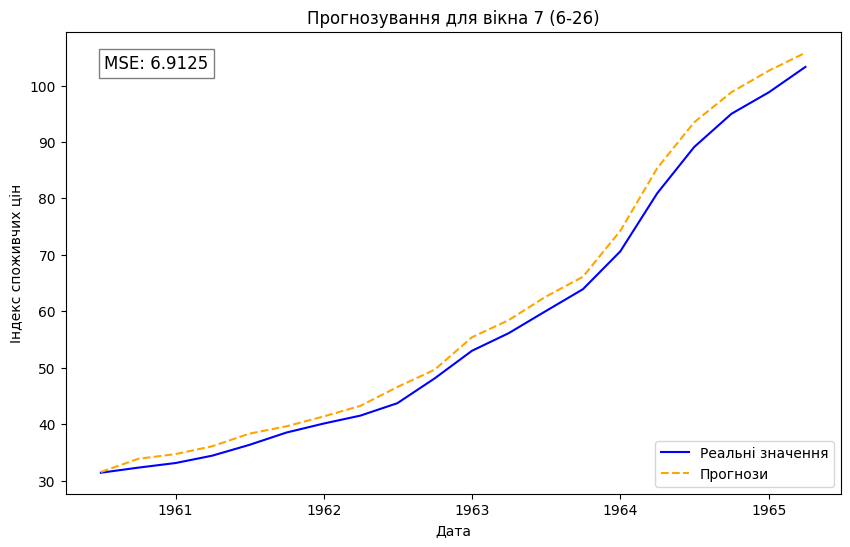

Training on window 8 (7-27)


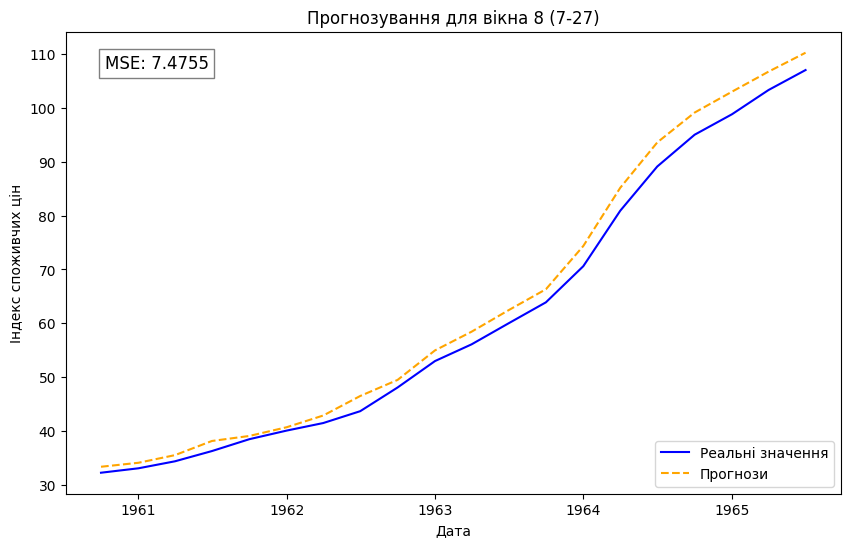

Training on window 9 (8-28)


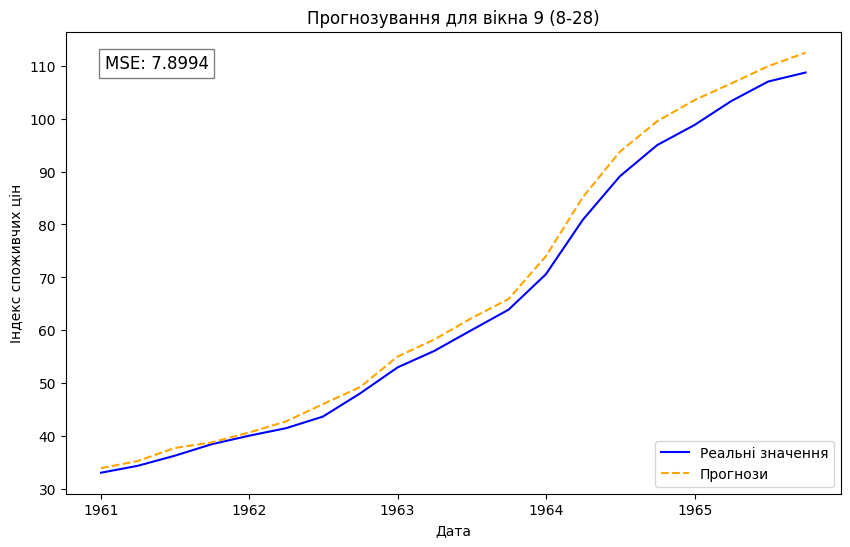

Training on window 10 (9-29)


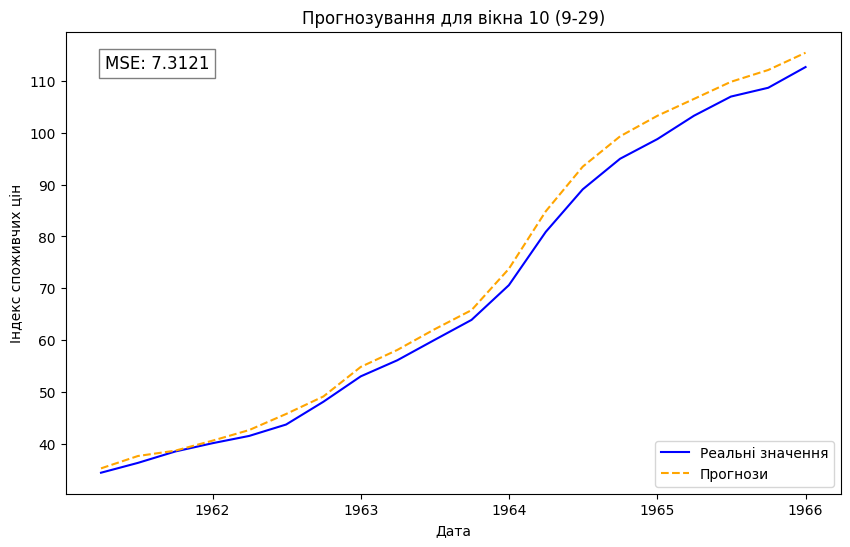

Training on window 11 (10-30)


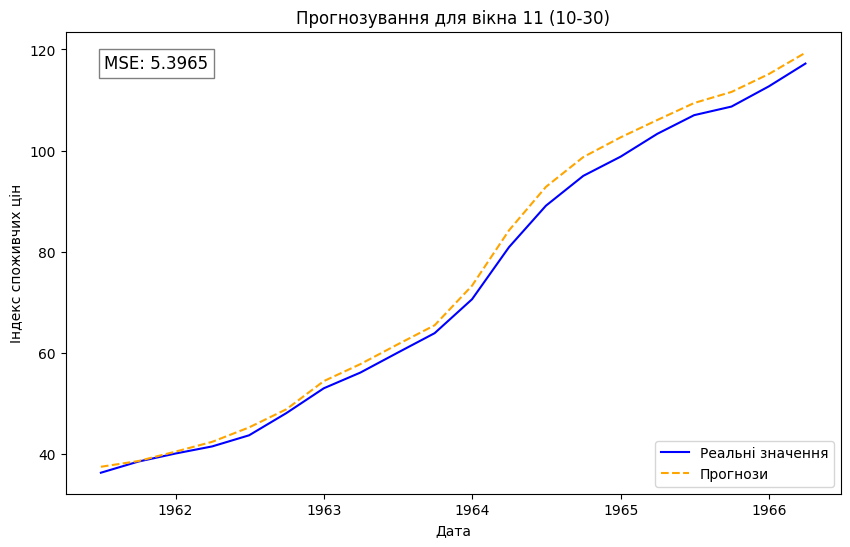

Training on window 12 (11-31)


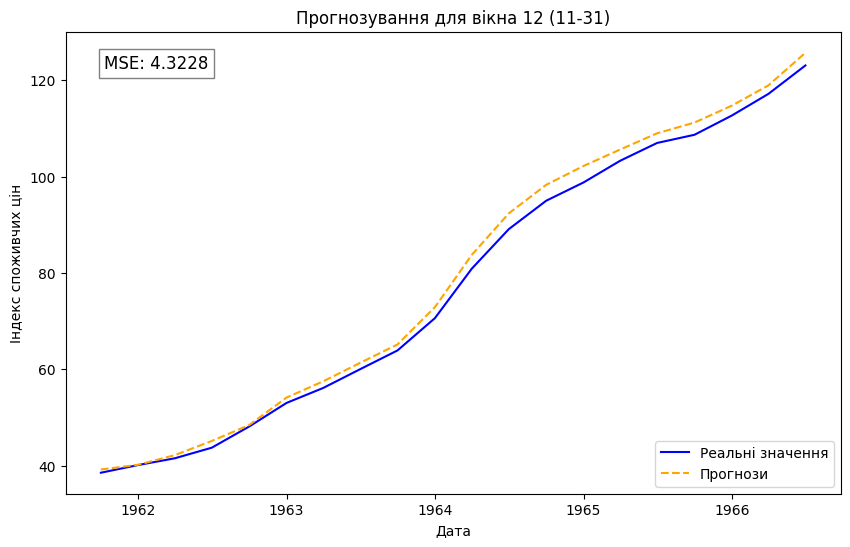

In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Нормалізуємо дані
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X
n_samples = X.shape[0]

# Ініціалізуємо модель один раз
model = NN(X.shape[1])
model.add_layer(DenseLayer(8, ReLU())) 
model.add_layer(DenseLayer(1, ReLU())) 

# Ініціалізуємо оптимізатор


def sliding_window_training(X, y, window_size=12, num_windows=10): 
    for window in range(num_windows):  # Цикл для всіх вікон
        start_index = window
        end_index = start_index + window_size
        
        if end_index > n_samples:
            break  # Вихід, якщо виходимо за межі даних
        
        print(f"Training on window {window + 1} ({start_index}-{end_index})")
        
        X_window = X_scaled[start_index:end_index]  # Використовуємо нормалізовані дані
        y_window = y[start_index:end_index].reshape(-1, 1)

        # Навчання мережі на поточному вікні
        model.fit(X_window, y_window, epochs=1000, optimizer=GDOptimizer(eta=0.1), loss_fn=MSE)

        # Прогнозування на основі навченої моделі
        predictions = model.forward(X_window)

        # Розрахунок DELTA та DELTA^2
        delta = predictions.flatten() - y_window.flatten()
        delta_squared = delta ** 2
        
        # Підготовка даних для таблиці
        results_df = pd.DataFrame({
            'Point': np.arange(window_size)[::-1],
            'IPC RO': y_window.flatten(),
            'IPC PO': predictions.flatten(),
            'DELTA': delta,
            'DELTA^2': delta_squared
        })
        
        # Обчислення TOTAL та MSE
        total_delta = delta.sum()
        total_delta_squared = delta_squared.sum()
        mse = np.mean(delta_squared)

        # Додавання підсумків до таблиці
        results_df.loc[len(results_df)] = ['TOTAL', '', total_delta, '', total_delta_squared]
        results_df.loc[len(results_df)] = ['MSE', '', '', '', mse]

        # Збереження результатів у Excel
        results_df.to_excel(f'full/sliding_window_results_window_{window + 1}.xlsx', index=False)

        # Візуалізація
        plt.figure(figsize=(10, 6))
        plt.plot(df['date'][start_index:end_index], y_window, label='Реальні значення', color='blue')
        plt.plot(df['date'][start_index:end_index], predictions, label='Прогнози', linestyle='--', color='orange')
        plt.xlabel('Дата')
        plt.ylabel('Індекс споживчих цін')
        plt.title(f'Прогнозування для вікна {window + 1} ({start_index}-{end_index})')
        plt.legend()

        # Додаємо MSE на графік
        plt.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.savefig(f'full/window_{window + 1}_forecast.png')  # Зберігаємо графік
        plt.show()

# Викликаємо функцію
sliding_window_training(X, y, window_size=20, num_windows=12)


In [8]:

X = year[['realgdp', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']].values 

Training on window 1 (0-20)


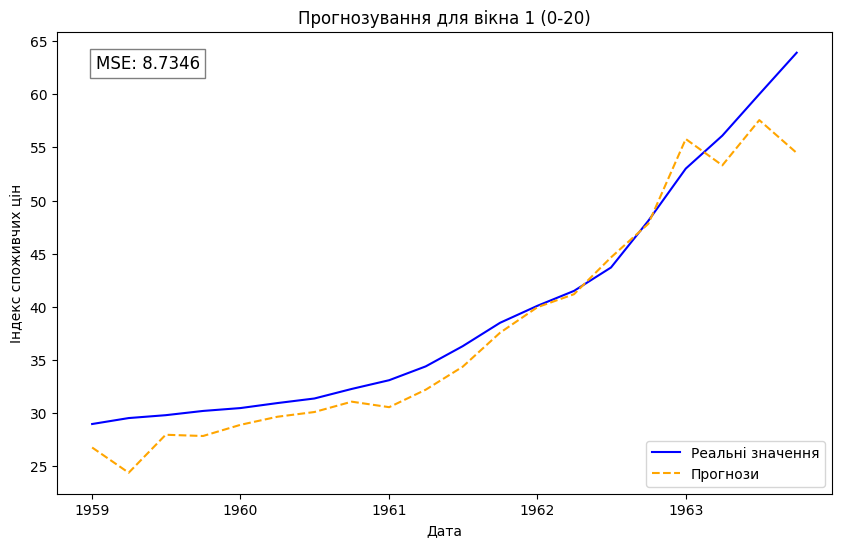

Training on window 2 (1-21)


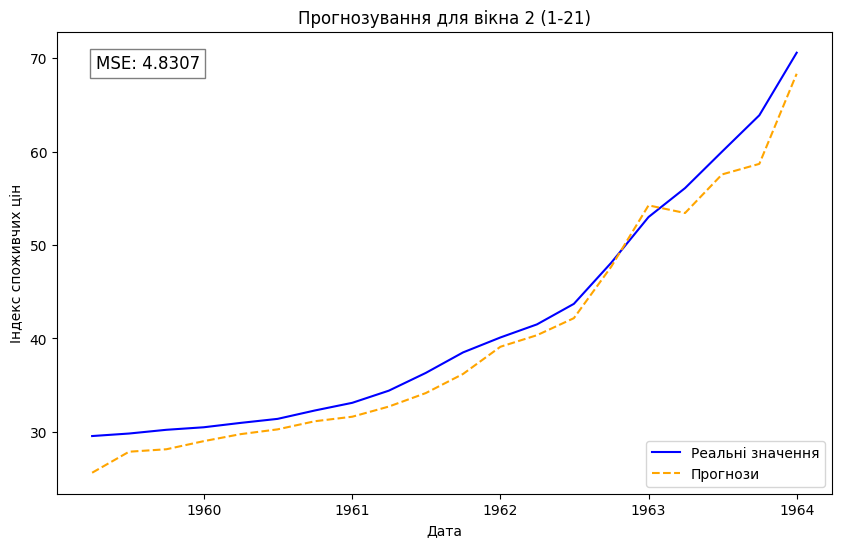

Training on window 3 (2-22)


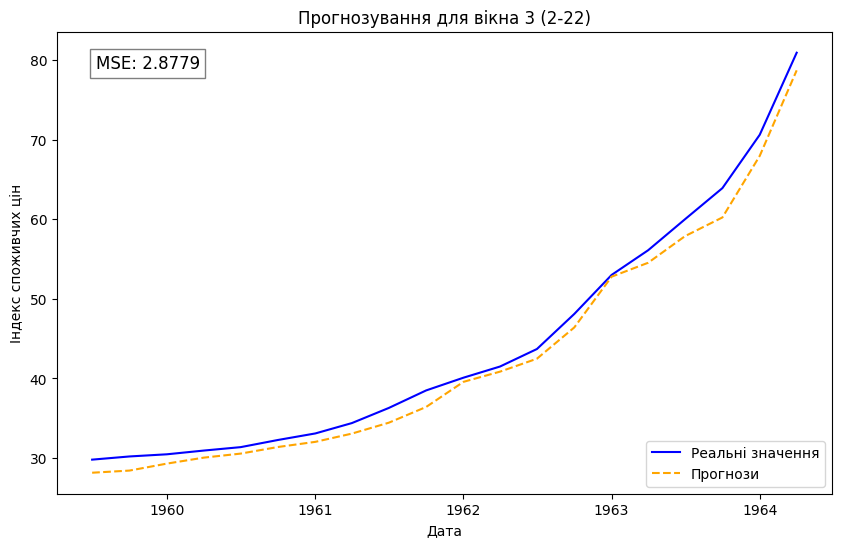

Training on window 4 (3-23)


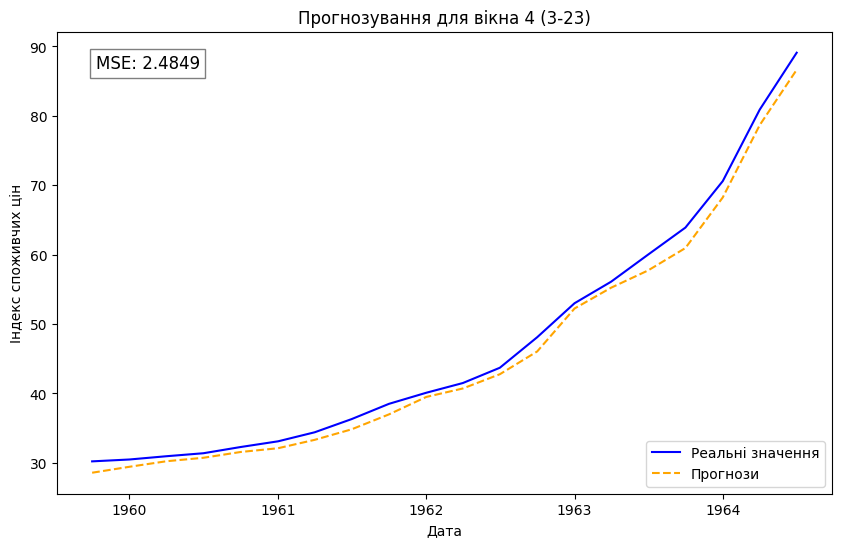

Training on window 5 (4-24)


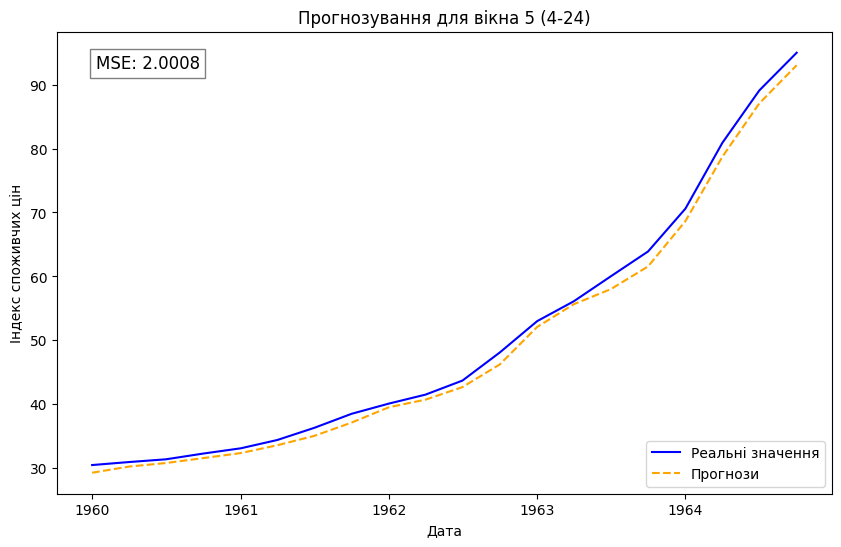

Training on window 6 (5-25)


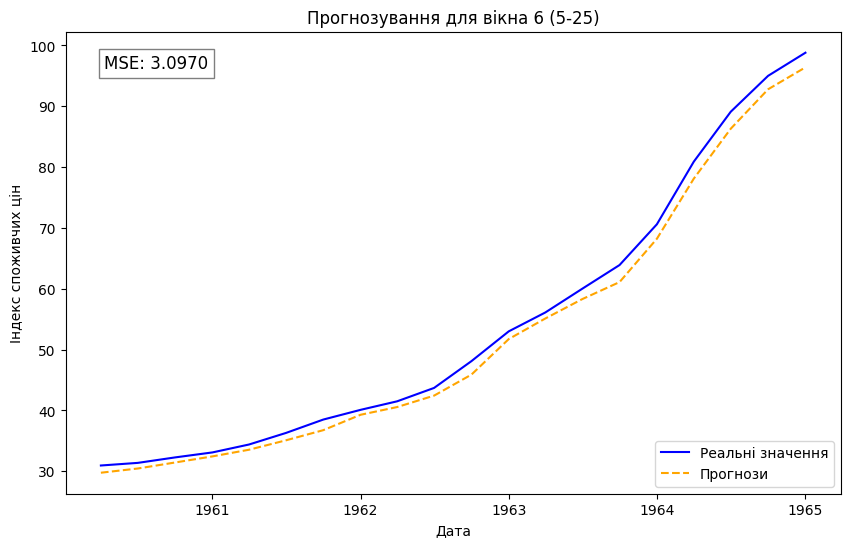

Training on window 7 (6-26)


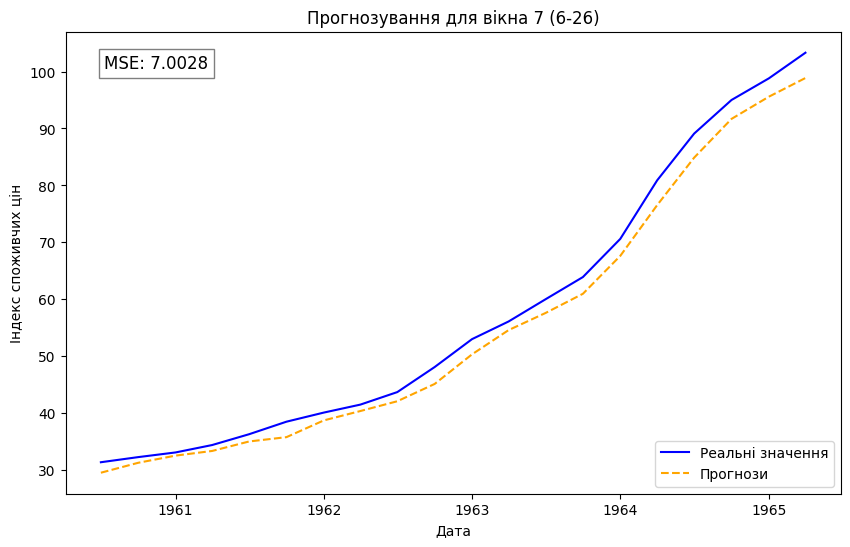

Training on window 8 (7-27)


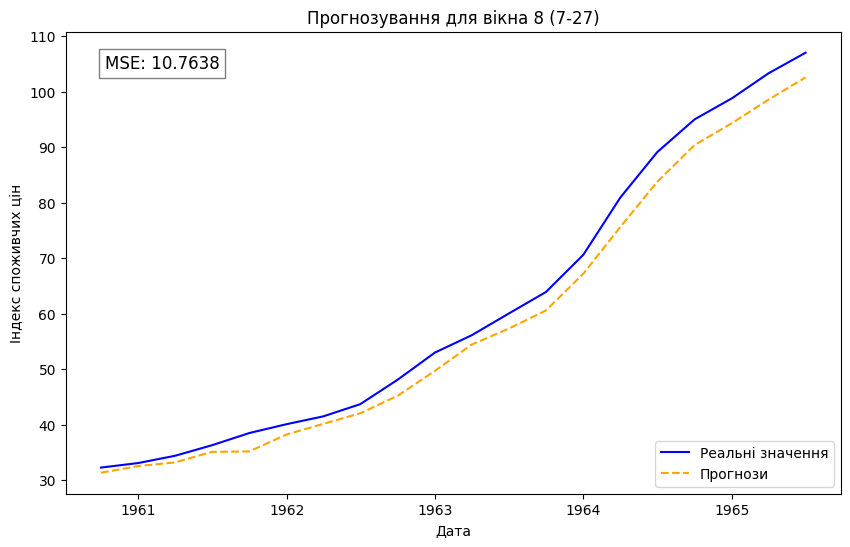

Training on window 9 (8-28)


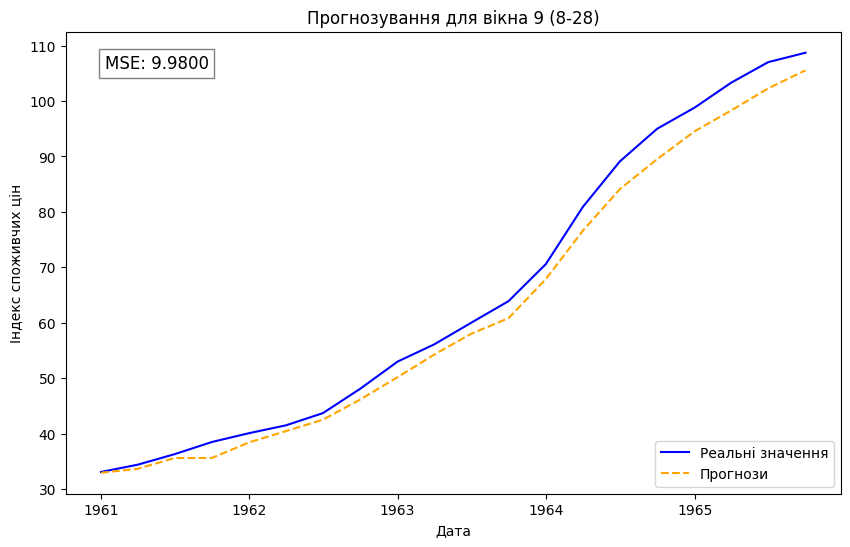

Training on window 10 (9-29)


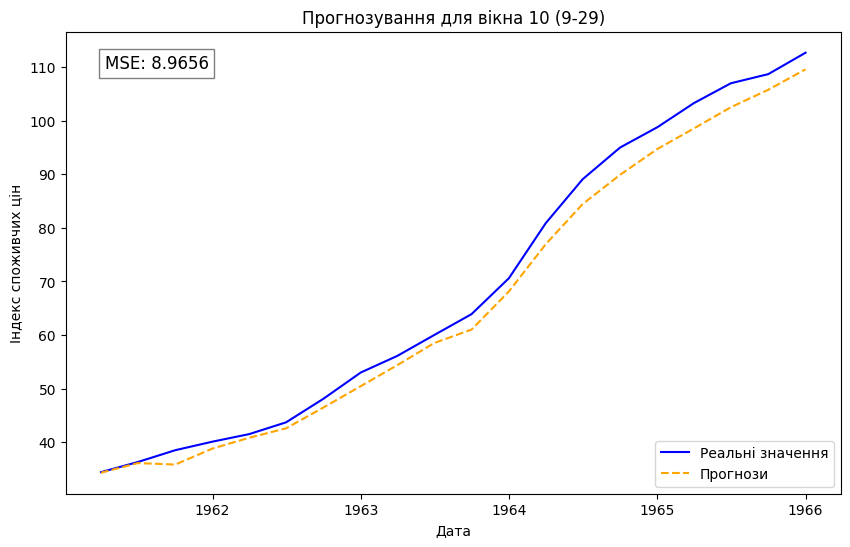

Training on window 11 (10-30)


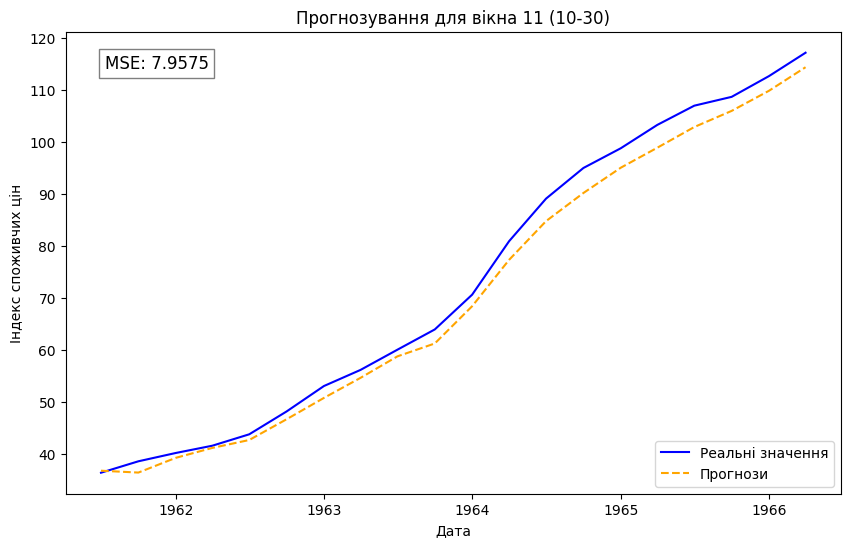

Training on window 12 (11-31)


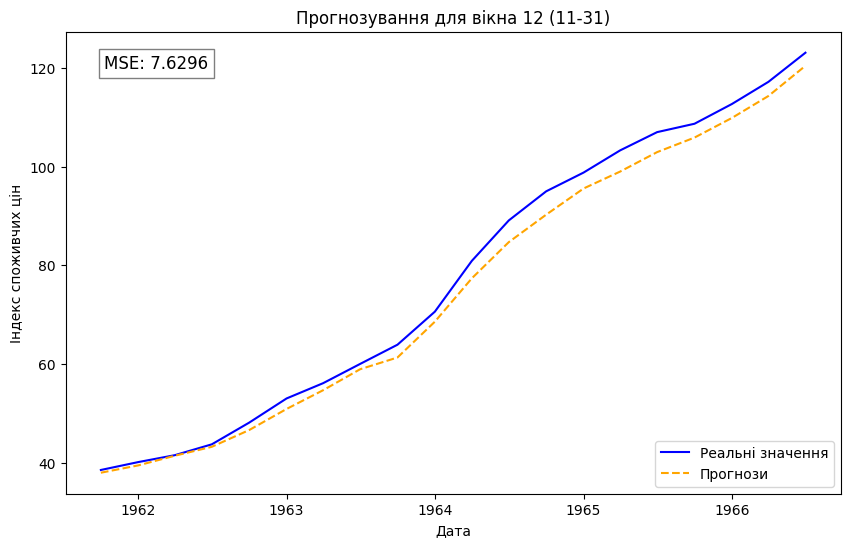

In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Нормалізуємо дані
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X
n_samples = X.shape[0]

# Ініціалізуємо модель один раз
model = NN(X.shape[1])
model.add_layer(DenseLayer(8, ReLU())) 
model.add_layer(DenseLayer(1, ReLU())) 

# Ініціалізуємо оптимізатор


def sliding_window_training(X, y, window_size=12, num_windows=10): 
    for window in range(num_windows):  # Цикл для всіх вікон
        start_index = window
        end_index = start_index + window_size
        
        if end_index > n_samples:
            break  # Вихід, якщо виходимо за межі даних
        
        print(f"Training on window {window + 1} ({start_index}-{end_index})")
        
        X_window = X_scaled[start_index:end_index]  # Використовуємо нормалізовані дані
        y_window = y[start_index:end_index].reshape(-1, 1)

        # Навчання мережі на поточному вікні
        model.fit(X_window, y_window, epochs=1000, optimizer=GDOptimizer(eta=0.1), loss_fn=MSE)

        # Прогнозування на основі навченої моделі
        predictions = model.forward(X_window)

        # Розрахунок DELTA та DELTA^2
        delta = predictions.flatten() - y_window.flatten()
        delta_squared = delta ** 2
        
        # Підготовка даних для таблиці
        results_df = pd.DataFrame({
            'Point': np.arange(window_size)[::-1],
            'IPC RO': y_window.flatten(),
            'IPC PO': predictions.flatten(),
            'DELTA': delta,
            'DELTA^2': delta_squared
        })
        
        # Обчислення TOTAL та MSE
        total_delta = delta.sum()
        total_delta_squared = delta_squared.sum()
        mse = np.mean(delta_squared)

        # Додавання підсумків до таблиці
        results_df.loc[len(results_df)] = ['TOTAL', '', total_delta, '', total_delta_squared]
        results_df.loc[len(results_df)] = ['MSE', '', '', '', mse]

        # Збереження результатів у Excel
        results_df.to_excel(f'partial/sliding_window_results_window_{window + 1}.xlsx', index=False)

        # Візуалізація
        plt.figure(figsize=(10, 6))
        plt.plot(df['date'][start_index:end_index], y_window, label='Реальні значення', color='blue')
        plt.plot(df['date'][start_index:end_index], predictions, label='Прогнози', linestyle='--', color='orange')
        plt.xlabel('Дата')
        plt.ylabel('Індекс споживчих цін')
        plt.title(f'Прогнозування для вікна {window + 1} ({start_index}-{end_index})')
        plt.legend()

        # Додаємо MSE на графік
        plt.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.savefig(f'partial/window_{window + 1}_forecast.png')  # Зберігаємо графік
        plt.show()

# Викликаємо функцію
sliding_window_training(X, y, window_size=20, num_windows=12)
